In [2]:
import numexpr as ne
import numpy as np
import tomocam
import tomopy
import dxchange as dx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import h5py
import os

In [3]:
def dXAtts(datafile, beamline='aps'):
    attrs = dict()
    fp = h5py.File(datafile, 'r')
    if beamline == 'als':
        gdata = dict(dx.reader._find_dataset_group(fp).attrs)
        attrs['pxsize']           = float(gdata['pxsize']) / 10  # /10 to convert units from mm to cm
        attrs['nslices']          = int(gdata['nslices'])
        attrs['nangles']          = int(gdata['nangles'])
        attrs['arange']           = float(gdata['arange'])
        attrs['nrays']            = int(gdata['nrays'])
        attrs['i0cycle']          = int(gdata['i0cycle'])
        attrs['num_dark_fields']  = int(gdata['num_dark_fields'])
        attrs['ind_dark']         = list(range(0, attrs['num_dark_fields']))
        attrs['num_bright_filed'] = int(gdata['num_bright_field'])
        attrs['rot_angle']        = float(gdata['rot_angle'])
    elif beamline == 'aps_32id' or beamline == 'aps_2bm':
        nangles, nslices, nrays = fp['exchange']['data'].shape
        attrs['nslices'] = nslices
        attrs['nangles'] = nangles
        attrs['nrays'] = nrays
    return attrs

# Input

In [4]:
filename = 'tomo_00002.h5'
inputPath = '/global/u2/d/dkumar/als/tomocam/data/tomo_00002/'
cor = 1029
inputFile = os.path.join(inputPath, filename)
gdata = dXAtts(inputFile, beamline='aps_32id')
print(gdata)

{'nslices': 1792, 'nangles': 1501, 'nrays': 2048}


In [5]:
help(dx.read_aps_2bm)

Help on function read_aps_2bm in module dxchange.exchange:

read_aps_2bm(fname, proj=None, sino=None)
    Read APS 2-BM standard data format.
    
    Parameters
    ----------
    fname : str
        Path to hdf5 file.
    
    proj : {sequence, int}, optional
        Specify projections to read. (start, end, step)
    
    sino : {sequence, int}, optional
        Specify sinograms to read. (start, end, step)
    
    Returns
    -------
    ndarray
        3D tomographic data.
    
    ndarray
        3D flat field data.
    
    ndarray
        3D dark field data.



# Output 

In [6]:
outputPath = '/global/u2/d/dkumar/als/tomocam/recon'
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
outputFile = os.path.join(outputPath, filename)

# Load data

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sinoUsed = (gdata['nslices']//2, gdata['nslices']//2 + 8, 1)
print(sinoUsed)
proj, flat, dark, theta = dx.read_aps_32id(inputFile, sino=sinoUsed)
proj = proj.astype(np.float32)
theta = theta.astype(np.float32)

(896, 904, 1)


## Normalize and minus-log

In [8]:
proj = tomopy.normalize(proj, flat, dark, out=proj)
minimum_transmission = 0.01
mx = np.float32(minimum_transmission)
ne.evaluate('where(proj>mx, proj, mx)', out=proj)
proj = tomopy.minus_log(proj)

# Remove stripes

In [9]:
proj = tomopy.prep.stripe.remove_stripe_fw(proj, level = 7, sigma = 3)

In [10]:
sino = np.transpose(proj, [1, 0, 2]).astype(np.float32)

# Reconstruct object using MBIR

In [34]:
s = 0.01   
max_iters = 150
recon = tomocam.MBIR(sino, theta, center = cor, num_iters = max_iters, smoothness = s)

Iteration:   0 , Error:  3928.810791015625
Iteration:   1 , Error:  1657.14892578125
Iteration:   2 , Error:  1352.1141357421875
Iteration:   3 , Error:  1033.57763671875
Iteration:   4 , Error:  734.73388671875
Iteration:   5 , Error:  477.5759582519531
Iteration:   6 , Error:  282.7384338378906
Iteration:   7 , Error:  171.66685485839844
Iteration:   8 , Error:  149.02923583984375
Iteration:   9 , Error:  158.95132446289062
Iteration:   10 , Error:  157.6298828125
Iteration:   11 , Error:  138.4955596923828
Iteration:   12 , Error:  107.49646759033203
Iteration:   13 , Error:  72.69815826416016
Iteration:   14 , Error:  42.227596282958984
Iteration:   15 , Error:  26.475271224975586
Iteration:   16 , Error:  30.134387969970703
Iteration:   17 , Error:  37.05622863769531
Iteration:   18 , Error:  39.5123176574707
Iteration:   19 , Error:  37.46581268310547
Iteration:   20 , Error:  32.6417121887207
Iteration:   21 , Error:  26.993391036987305
Iteration:   22 , Error:  22.0698318481445

# Mask each reconstructed slice with a circle.

In [35]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

# Show results

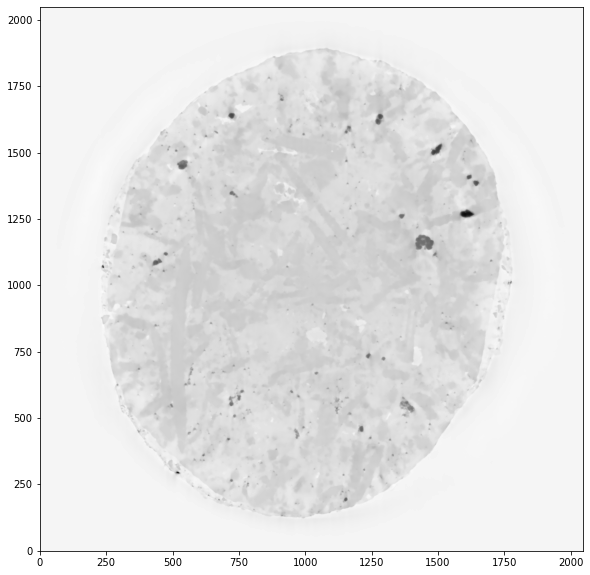

In [36]:
plt.imshow(recon[0], origin='lower', cmap='gray')

# Save to hdf5

In [37]:
with h5py.File(outputFile, 'w') as fp:
    dset = fp.create_dataset('recon', data = recon)
    dset.attrs['smoothness'] = s
    dset.attrs['num_iters'] = max_iters
    dset.attrs['remove_stripe_fw'] = 'level : 7, sigma: 3'
    dset.attrs['minimum_transmission'] = minimum_transmission